Datasets used: 
- `Subject List Dataset(SSL)` :<br>
The information displayed represents a de-identified listing of arrest data from August 1, 2012 to July 31, 2016, that was used by the Chicago Police Department’s Strategic Subject Algorithm,<br> created by the Illinois Institute of Technology and funded through a Department of Justice Bureau of Justice Assistance grant,<br> to create a risk assessment score known as the Strategic Subject List or “SSL.” <br>These scores reflect an individual’s probability of being involved in a shooting incident either as a victim or an offender.<br> Scores are calculated and placed on a scale ranging from 0 (extremely low risk) to 500 (extremely high risk).

Reference Links: https://data.cityofchicago.org/Public-Safety/Strategic-Subject-List-Historical/4aki-r3np

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse
from aif360.sklearn.datasets import fetch_adult
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

## Load Dataset

In [2]:
urlfile= "https://raw.githubusercontent.com/samuel-yeom/fliptest/master/exact-ot/chicago-ssl-clean.csv"

X = pd.read_csv(urlfile)
num_features = X._get_numeric_data().columns.to_list()

#Values >= 345 (High Risk) are considered unfavorable
X['SSL SCORE'] = np.where((X['SSL SCORE'] >= 345) , 0, 1)

df = X.copy()
cate_features = df.select_dtypes(include=['object']).columns.to_list()

df.head()

,SSL SCORE,PREDICTOR RAT AGE AT LATEST ARREST,PREDICTOR RAT VICTIM SHOOTING INCIDENTS,PREDICTOR RAT VICTIM BATTERY OR ASSAULT,PREDICTOR RAT ARRESTS VIOLENT OFFENSES,PREDICTOR RAT GANG AFFILIATION,PREDICTOR RAT NARCOTIC ARRESTS,PREDICTOR RAT TREND IN CRIMINAL ACTIVITY,PREDICTOR RAT UUW ARRESTS,SEX CODE CD,RACE CODE CD
0,0,20-30,0,1,4,1,1,1.0,1,M,BLK
1,0,20-30,0,9,1,1,0,1.0,0,M,WHI
2,0,less than 20,1,2,1,1,3,1.0,0,M,WHI
3,0,less than 20,1,1,4,1,0,1.6,1,M,BLK
4,0,less than 20,0,0,5,0,0,1.3,3,M,BLK


## Model training and test

In [5]:
X = df.drop('SSL SCORE', axis=1)
y = df['SSL SCORE']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [6]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='SSL SCORE')
model.predict(X_test.iloc[:100, :])

Wall time: 11.3 s


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [7]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.83      0.61      0.71     11432
           1       0.96      0.99      0.97    108143

    accuracy                           0.95    119575
   macro avg       0.89      0.80      0.84    119575
weighted avg       0.95      0.95      0.95    119575



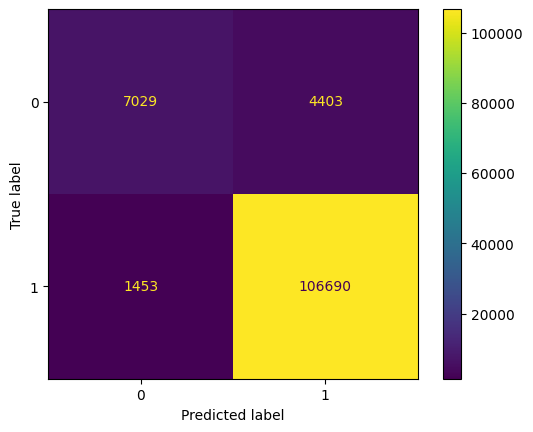

In [8]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [9]:
for col in cate_features:
    X_test[col] = X_test[col].astype('object')

In [13]:
#ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
#    X_test,
#     model=model,
#     sensitive_attribute='SEX CODE CD',
#     missing_subgroup_val="X"
# )

#print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
#rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

100%|██████████| 14548/14548 [02:56<00:00, 82.60it/s] 


Number of if-thens: 14548


In [14]:
 #### Uncomment if you wish to save rules object on disk

#import dill

#with open("rulesSSL.data", "wb") as outf:
#     dill.dump(rules_by_if, outf)

In [10]:

import dill

with open("rulesAdultFairTest.data", "rb") as inf:
    rules_by_if = dill.load(inf)


'\nimport dill\n\nwith open("rulesAdult.data", "rb") as inf:\n    rules_by_if = dill.load(inf)\n'

In [16]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["M"][1][0][1]-e[1]["F"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT AGE AT LATEST ARREST = 20-30:
	Subgroup 'F', 2.7581% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with correctness 85.7143%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with correctness 100.0000%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT AGE AT LATEST ARREST = 40-50 with correctness 100.0000%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT AGE AT LATEST ARREST = less than 20 with correctness 0.0000%.
		Make PREDICTOR RAT TREND IN C

# Filter rules by different scoring functions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [17]:
feature_weights = {"SEX CODE CD": 1, "RACE CODE CD": 1}
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## For each if-group, inner product of then costs and correctness-es, divided by the number of terms

In [24]:
rules_max_costdiff_sorted = gfacts.sort_triples_by_max_costdiff(rules_by_if, params=params)

top = dict(rules_max_costdiff_sorted[:K])
print(recourse_report_reverse(
    top,
    population_sizes = {"M": (X["SEX CODE CD"] == "M").sum(), "F": (X["SEX CODE CD"] == "F").sum()},
    missing_subgroup_val="X",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()))
))

If RACE CODE CD = BLK, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 2:
	Subgroup 'F', 3.4673% covered out of 96295
		Make RACE CODE CD = BLK, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 86.3636%.
		Make RACE CODE CD = WWH, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 88.6364%.
		Make RACE CODE CD = WHI, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 88.6364%.
		Make RACE CODE CD = API, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 88.6364%.
		Aggregate cost of the above recourses = 1.54545
	Subgroup 'M', 2.6345% covered out of 302230
		Make RACE CODE CD = BLK, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 37.8947%.
		Make RACE CODE CD = WWH, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 40.0000%.
		Make RACE CODE CD = WHI, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 43.6842%.
		Make RACE CODE CD = API, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 41.0526%.
		Aggrega

#### Filter rules that are approximately contained in other rules.

First, we filter only the top rules.

In [25]:
print(recourse_report_reverse(
    gfacts.filter_contained_rules(top),
    population_sizes = {"M": (X["SEX CODE CD"] == "M").sum(), "F": (X["SEX CODE CD"] == "F").sum()},
    missing_subgroup_val="X",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()))
))

If RACE CODE CD = BLK, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 2:
	Subgroup 'F', 3.4673% covered out of 96295
		Make RACE CODE CD = BLK, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 86.3636%.
		Make RACE CODE CD = WWH, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 88.6364%.
		Make RACE CODE CD = WHI, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 88.6364%.
		Make RACE CODE CD = API, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 88.6364%.
		Aggregate cost of the above recourses = 1.54545
	Subgroup 'M', 2.6345% covered out of 302230
		Make RACE CODE CD = BLK, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 37.8947%.
		Make RACE CODE CD = WWH, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 40.0000%.
		Make RACE CODE CD = WHI, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 43.6842%.
		Make RACE CODE CD = API, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 41.0526%.
		Aggrega

Now, we filter all rules, and then pick the top.

In [26]:
rules_max_costdiff_sorted_filtered = gfacts.filter_contained_rules(dict(gfacts.sort_triples_by_max_costdiff(rules_by_if, params=params)))

top = dict(list(rules_max_costdiff_sorted_filtered.items())[:K])
print(recourse_report_reverse(
    top,
    population_sizes = {"M": (X["SEX CODE CD"] == "M").sum(), "F": (X["SEX CODE CD"] == "F").sum()},
    missing_subgroup_val="X",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()))
))

If PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 2:
	Subgroup 'F', 3.7825% covered out of 96295
		Make PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 85.4167%.
		Make PREDICTOR RAT UUW ARRESTS = 1, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 64.5833%.
		Make PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1 with correctness 33.3333%.
		Aggregate cost of the above recourses = 0.826389
	Subgroup 'M', 2.8286% covered out of 302230
		Make PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 50.0000%.
		Make PREDICTOR RAT UUW ARRESTS = 1, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 38.2353%.
		Make PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1 with correctness 14.7059%.
		Aggregate cost of the above recourses = 0.470588
If PREDICTOR RAT NARCOTIC ARRESTS = 2, RACE CODE CD = BLK, PREDICTOR RAT AGE

## For each if-group, minimum cost of change among thens that surpass a correctness threshold

In [27]:
rules_max_costdiff_sorted = gfacts.sort_triples_by_max_costdiff_ignore_nans(
    rules_by_if,
    params=params,
    group_calculator=gfacts.if_group_cost_max_change_correctness_threshold,
    cor_thres=0.5
)

pop_sizes = {sg: (X["SEX CODE CD"] == sg).sum() for sg in X["SEX CODE CD"].unique()}
top = dict(rules_max_costdiff_sorted[:K])
print(recourse_report_reverse(
    top,
    population_sizes = pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(
        list(top.keys()),
        list(top.values()),
        group_calculator=gfacts.if_group_cost_max_change_correctness_threshold,
        cor_thres=0.5
    )
))

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.5, RACE CODE CD = BLK:
	Subgroup 'F', 2.6793% covered out of 96295
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = BLK with correctness 70.5882%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = BLK with correctness 70.5882%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = BLK with correctness 55.8824%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WWH with correctness 73.5294%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WWH with correctness 70.5882%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WHI with correctness 73.5294%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WHI with correctness 73.5294%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = WWH with correctness 64.7059%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = WHI 

Now the pruned rules.

In [28]:
print(recourse_report_reverse(
    gfacts.filter_contained_rules(top),
    population_sizes = {"M": (X['SEX CODE CD'] == "M").sum(), "F": (X['SEX CODE CD'] == "F").sum()},
    missing_subgroup_val="X",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()))
))

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.5, RACE CODE CD = BLK:
	Subgroup 'F', 2.6793% covered out of 96295
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = BLK with correctness 70.5882%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = BLK with correctness 70.5882%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = BLK with correctness 55.8824%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WWH with correctness 73.5294%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WWH with correctness 70.5882%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WHI with correctness 73.5294%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WHI with correctness 73.5294%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = WWH with correctness 64.7059%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = WHI 

## For each if-group, minimum cost of change among thens that surpass a correctness threshold

Before, when, for a subgroup, there were no thens that surpassed the threshold, the minimum cost of change was valued as infinity, and thus, as it is evident in the results, the algorithm finds many rules for which some groups surpass the threshold and some groups do not (because for those rules the difference between maximum and minimum cost of the subgroups evaluates to infinity).

Here, the difference is that we will ignore altogether rules for which the correctness drops below the threshold for all recourses (for some subgroup), considering them as "empty".

In [29]:
rules_max_costdiff_sorted = gfacts.sort_triples_by_max_costdiff_ignore_nans_infs(
    rules_by_if,
    params=params,
    group_calculator=gfacts.if_group_cost_max_change_correctness_threshold,
    cor_thres=0.5
)

pop_sizes = {sg: (X["SEX CODE CD"] == sg).sum() for sg in X["SEX CODE CD"].unique()}
top = dict(rules_max_costdiff_sorted[:K])
print(recourse_report_reverse(
    gfacts.filter_by_correctness(top, threshold=0.5),
    population_sizes = pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(
        list(top.keys()),
        list(top.values()),
        group_calculator=gfacts.if_group_cost_max_change_correctness_threshold,
        cor_thres=0.5
    )
))

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.5, RACE CODE CD = BLK:
	Subgroup 'F', 2.6793% covered out of 96295
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = BLK with correctness 70.5882%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = BLK with correctness 70.5882%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = BLK with correctness 55.8824%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WWH with correctness 73.5294%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WWH with correctness 70.5882%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WHI with correctness 73.5294%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WHI with correctness 73.5294%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = WWH with correctness 64.7059%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = WHI 

Now the pruned rules.

In [30]:
print(recourse_report_reverse(
    gfacts.filter_by_correctness(gfacts.filter_contained_rules(top), threshold=0.5),
    population_sizes = {"M": (X['SEX CODE CD'] == "M").sum(), "F": (X['SEX CODE CD'] == "F").sum()},
    missing_subgroup_val="X",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()))
))

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.5, RACE CODE CD = BLK:
	Subgroup 'F', 2.6793% covered out of 96295
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = BLK with correctness 70.5882%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = BLK with correctness 70.5882%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = BLK with correctness 55.8824%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WWH with correctness 73.5294%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WWH with correctness 70.5882%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WHI with correctness 73.5294%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WHI with correctness 73.5294%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = WWH with correctness 64.7059%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = WHI 